In [1]:
# sys path
from sys import path
from pathlib import Path

module_path = str(Path.cwd().parents[0])

if module_path not in path:
    path.append(module_path)
    
path.append(module_path + '\\functions')



# libraries
import pandas as pd
import numpy as np
import casadi as ca
import scipy.linalg
import matplotlib.pyplot as plt

from gp_regression import GPR
import save_outputs
import time

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Import model, inputs and outputs

In [2]:
gp = GPR.load_model('models/IEEE39')

In [3]:
input_dict = save_outputs.load_model('IEEE39 - pandapower\inputs\IEEE39_TA1')

x_d = np.array(input_dict['xd'])
xd_std = np.array(input_dict['xd_std'])
u = np.array(input_dict['u'])

In [5]:
# TA1
TA1_dict = save_outputs.load_model('outputs\IEEE39_TA1')

x_TA1 = np.array(TA1_dict['x']).reshape(1,-1)
s_TA1 = np.array(TA1_dict['s']).reshape(1,-1)


# TA2
TA2_dict = save_outputs.load_model('outputs\IEEE39_TA2')

x_TA2 = np.array(TA2_dict['x']).reshape(1,-1)
s_TA2 = np.array(TA2_dict['s']).reshape(1,-1)

# EM
EM_dict = save_outputs.load_model('outputs\IEEE39_EM')

x_EM = np.array(EM_dict['x']).reshape(1,-1)
s_EM = np.array(EM_dict['s']).reshape(1,-1)

# Monte Carlo

## 1. Power Flow 

### a) Mean value

In [10]:
# Data Set

df_pf_mean = pd.read_csv('datasets\dataset_tested_real.csv')
df_pf_mean

,Unnamed: 0,Pg0,Pg1,Pg2,Pg3,Pg4,Pg5,Pg6,Pg7,Pg8,Pg9,Load_P1,Load_P2,Load_P3,Load_P4,Load_P5,Load_P6,Load_P7,Load_P8,Load_P9,Load_P10,Load_P11,Load_P12,Load_P13,Load_P14,Load_P15,Load_P16,Load_P17,Load_P18,Load_P19,Load_P20,Load_P21,Load_Q1,Load_Q2,Load_Q3,Load_Q4,Load_Q5,Load_Q6,Load_Q7,Load_Q8,Load_Q9,Load_Q10,Load_Q11,Load_Q12,Load_Q13,Load_Q14,Load_Q15,Load_Q16,Load_Q17,Load_Q18,Load_Q19,Load_Q20,Load_Q21,RS_P1,RS_P2,RS_P3,RS_P4,RS_P5,RS_P6,RS_Q1,RS_Q2,RS_Q3,RS_Q4,RS_Q5,RS_Q6,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,U11,U12,U13,U14,U15,U16,U17,U18,U19,U20,U21,U22,U23,U24,U25,U26,U27,U28,P_0_1,P_0_38,P_1_2,P_1_24,P_2_3,P_2_17,P_3_4,P_3_13,P_4_5,P_4_7,P_5_6,P_5_10,P_6_7,P_7_8,P_8_38,P_9_10,P_9_12,P_12_13,P_13_14,P_14_15,P_15_16,P_15_18,P_15_20,P_15_23,P_16_17,P_16_26,P_20_21,P_21_22,P_22_23,P_22_35,P_24_25,P_25_26,P_25_27,P_25_28,P_27_28
0,0,501.09879,501.09879,501.09879,501.09879,491.468412,501.09879,498.293357,496.776703,501.09879,501.09879,97.6,322.0,500.0,233.8,522.0,6.5,8.53,320.0,329.0,158.0,680.0,274.0,247.5,308.6,224.0,139.0,281.0,206.0,283.5,9.2,1104.0,44.2,2.4,184.0,84.0,176.6,-66.6,88.0,153.0,32.3,30.0,103.0,115.0,84.6,-92.2,47.2,17.0,75.5,27.6,26.9,4.6,250.0,210.0,210.0,210.0,210.0,210.0,210.0,70.0,70.0,70.0,70.0,70.0,70.0,-125.764049,-160.968205,-129.351181,-48.679028,-139.900385,-99.356496,-42.199838,27.07984,108.005468,101.804402,1.032769,1.057637,1.042823,1.01716,1.015348,1.017433,1.00603,1.004803,1.038169,1.030635,1.026006,1.031015,1.030035,1.02856,1.040946,1.052565,1.051478,1.046858,1.058554,0.995703,1.049436,1.064062,1.058143,1.060932,1.062736,1.067564,1.054746,1.068323,1.067904,-471.600111,374.000111,390.18451,-157.997261,147.44475,-81.104392,-19.232607,-333.750726,-477.924721,458.687366,539.633144,-481.752067,304.082981,238.729586,230.71678,371.762118,129.336671,218.302449,-116.744057,-227.014723,332.334402,-306.871996,-352.357481,-229.63911,239.550925,92.085153,-627.274287,80.948635,330.582359,-497.188039,111.524375,189.537075,-83.961559,-133.421368,-290.229599


In [11]:
def _get_outputs(df):
    V = df[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
             'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
             'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
             'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
             'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
             'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']]
    return V 


out_pf_mean = _get_outputs(df_pf_mean)


out_pf_mean[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
      'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28']] = out_pf_mean[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
                                                                                                 'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28']]*345

out_pf_mean = np.array(out_pf_mean)
out_pf_mean.shape

c:\users\mile\python\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(1, 74)

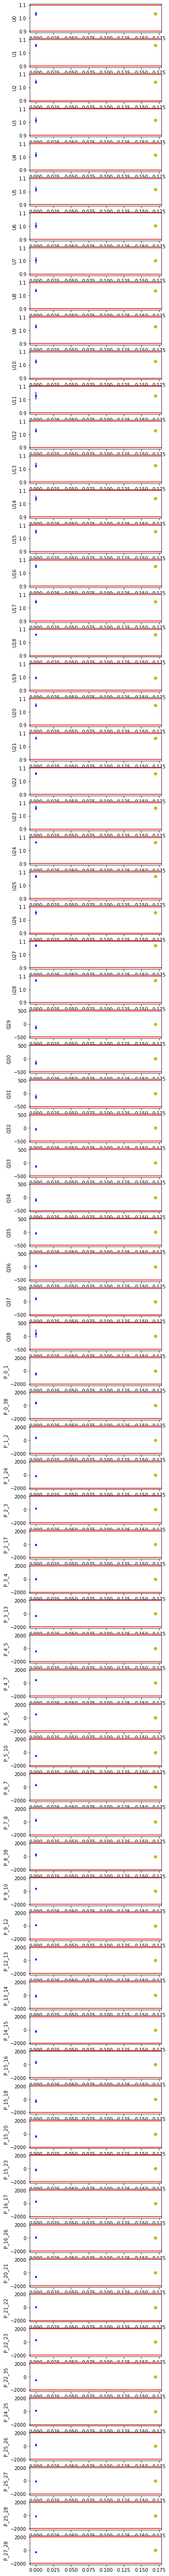

In [12]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

m = 1

t1 = np.arange(0,m)
t2 = np.arange(0,m)+0.17


x_names = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
            'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
            'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
            'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
            'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
            'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']
u_names = ['Pg0', 'Pg1', 'Pg2', 'Pg3', 'Pg4', 'Pg5', 'Pg6', 'Pg7', 'Pg8', 'Pg9']
d_names = ['Load_P1', 'Load_P2', 'Load_P3', 'Load_P4', 'Load_P5', 'Load_P6','Load_P7', 'Load_P8', 'Load_P9',
            'Load_P10', 'Load_P11', 'Load_P12', 'Load_P13', 'Load_P14', 'Load_P15','Load_P16', 'Load_P17', 'Load_P18',
            'Load_P19', 'Load_P20', 'Load_P21', 'RS_P1', 'RS_P2', 'RS_P3', 'RS_P4', 'RS_P5', 'RS_P6']



fig_x = plt.figure(figsize=(5, 100))
for i in range(x_TA1.shape[1]):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
            if i<29:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_mean[:, i]/345, color='y', label='MC PF')
                
                ax.axhline(y=1.1, xmin=0, xmax=1, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=1, color='r')
                
            elif i>28 and i<39:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_mean[:, i]/345, color='y', label='MC PF')
                
                ax.axhline(y=500,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-500, xmin=0, xmax=1, color='r')
                
            elif i>38 and i<89:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_mean[:, i]/345, color='y', label='MC PF')
                
                ax.axhline(y=2000,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-2000, xmin=0, xmax=1, color='r')
                
            
            ax.set_ylabel(x_names[i])   

### b) Uncertanty

In [13]:
# Data Set

df_pf_uncertanty = pd.read_csv('datasets\dataset_tested_uncertanty.csv')
df_pf_uncertanty.head()

,Unnamed: 0,Pg0,Pg1,Pg2,Pg3,Pg4,Pg5,Pg6,Pg7,Pg8,Pg9,Load_P1,Load_P2,Load_P3,Load_P4,Load_P5,Load_P6,Load_P7,Load_P8,Load_P9,Load_P10,Load_P11,Load_P12,Load_P13,Load_P14,Load_P15,Load_P16,Load_P17,Load_P18,Load_P19,Load_P20,Load_P21,Load_Q1,Load_Q2,Load_Q3,Load_Q4,Load_Q5,Load_Q6,Load_Q7,Load_Q8,Load_Q9,Load_Q10,Load_Q11,Load_Q12,Load_Q13,Load_Q14,Load_Q15,Load_Q16,Load_Q17,Load_Q18,Load_Q19,Load_Q20,Load_Q21,RS_P1,RS_P2,RS_P3,RS_P4,RS_P5,RS_P6,RS_Q1,RS_Q2,RS_Q3,RS_Q4,RS_Q5,RS_Q6,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,U11,U12,U13,U14,U15,U16,U17,U18,U19,U20,U21,U22,U23,U24,U25,U26,U27,U28,P_0_1,P_0_38,P_1_2,P_1_24,P_2_3,P_2_17,P_3_4,P_3_13,P_4_5,P_4_7,P_5_6,P_5_10,P_6_7,P_7_8,P_8_38,P_9_10,P_9_12,P_12_13,P_13_14,P_14_15,P_15_16,P_15_18,P_15_20,P_15_23,P_16_17,P_16_26,P_20_21,P_21_22,P_22_23,P_22_35,P_24_25,P_25_26,P_25_27,P_25_28,P_27_28
0,0,584.886269,584.886269,584.886269,584.886269,502.918826,584.886269,555.678990,543.954509,584.886269,584.886269,81.706368,337.396277,406.927275,265.628276,602.773770,7.786857,7.181189,268.510366,423.369532,140.083816,878.401985,330.990070,262.154822,331.496010,232.436519,115.783222,257.538098,207.142983,304.575527,6.717041,1226.455086,37.002269,2.514755,149.749237,95.435309,203.926911,-79.785330,74.084950,128.381519,41.564851,26.598193,133.052065,138.919190,89.609285,-99.040610,48.977695,14.160538,69.196179,27.753138,28.899759,3.358520,277.729866,184.555024,163.711989,110.276773,157.886078,321.529547,60.339472,61.518341,54.570663,36.758924,52.628693,107.176516,20.113157,-143.152139,-192.469465,-152.768866,-75.255754,-173.341606,-134.547332,-61.493819,13.288683,56.732426,90.168122,1.032259,1.055922,1.041386,1.016336,1.010822,1.012783,0.999401,0.997986,1.037041,1.027667,1.022426,1.027473,1.027237,1.026499,1.037864,1.050053,1.049690,1.045506,1.054868,0.989780,1.043965,1.059995,1.054838,1.060454,1.060515,1.064784,1.053071,1.062070,1.060288,-487.526822,405.820454,421.498014,-147.415850,118.884373,-36.923526,4.884299,-293.259247,-512.077754,516.947229,603.603279,-489.908453,335.753752,247.315048,237.827744,403.527912,181.358357,248.871174,-45.608454,-203.919957,261.866349,-202.850887,-353.280670,-333.479255,177.239291,84.190551,-685.218380,54.088487,346.200164,-554.297501,160.788893,173.873324,-39.781149,-89.841501,-246.987985
1,1,552.436610,552.436610,552.436610,552.436610,498.204113,552.436610,533.112064,525.354742,552.436610,552.436610,112.201137,394.986317,476.528991,292.900567,626.291284,5.795892,7.528137,295.976239,315.760805,162.084564,721.614234,331.929377,197.994813,283.835490,254.441420,103.373119,312.782687,232.094481,347.962164,8.933786,1146.491194,50.812400,2.943997,175.362669,105.233737,211.883220,-59.385603,77.664250,141.513639,31.000225,30.775550,109.303333,139.313425,67.678227,-84.801141,53.614442,12.642756,84.039476,31.096154,33.016516,4.466893,259.622100,244.895597,175.107667,264.285169,217.447328,148.388806,157.654940,81.631866,58.369222,88.095056,72.482443,49.462935,52.551647,-143.778111,-205.970275,-165.750307,-69.517436,-153.668348,-128.807245,-57.137495,7.596878,72.057269,64.905312,1.029796,1.055266,1.037225,1.009886,1.005348,1.007702,0.993123,0.991737,1.032093,1.024014,1.018235,1.023463,1.023405,1.022108,1.036955,1.046506,1.045087,1.040637,1.055582,0.993278,1.042068,1.060455,1.055291,1.053607,1.058811,1.062553,1.048209,1.062551,1.062511,-493.062045,380.860908,424.676007,-128.449994,141.213016,-113.748898,27.484080,-363.233852,-500.024069,527.493089,619.035139,-525.715486,323.760374,222.255924,214.995725,430.036436,122.400175,191.328429,-173.288203,-205.544395,429.158258,-322.572353,-382.412164,-245.891612,276.466660,151.513817,-715.441899,50.641126,384.458544,-531.841459,139.613413,161.977058,-35.159497,-91.149016,-267.301515
2,2,450.363647,450.363647,450.363647,450.363647,483.373611,450.363647,462.126015,466.847703,450.363647,450.363647,101.742805,267.100927,436.328991,194.651033,529.504577,5.768038,10.868799,373.948928,290.539119,125.945

In [14]:
def _get_outputs(df):
    V = df[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
             'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
             'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
             'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
             'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
             'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']]
    return V 


out_pf_uncertanty = _get_outputs(df_pf_uncertanty)


out_pf_uncertanty[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
      'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28']] = out_pf_uncertanty[['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
                                                                                                 'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28']]*345

out_pf_uncertanty = np.array(out_pf_uncertanty)
out_pf_uncertanty.shape

c:\users\mile\python\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(5000, 74)

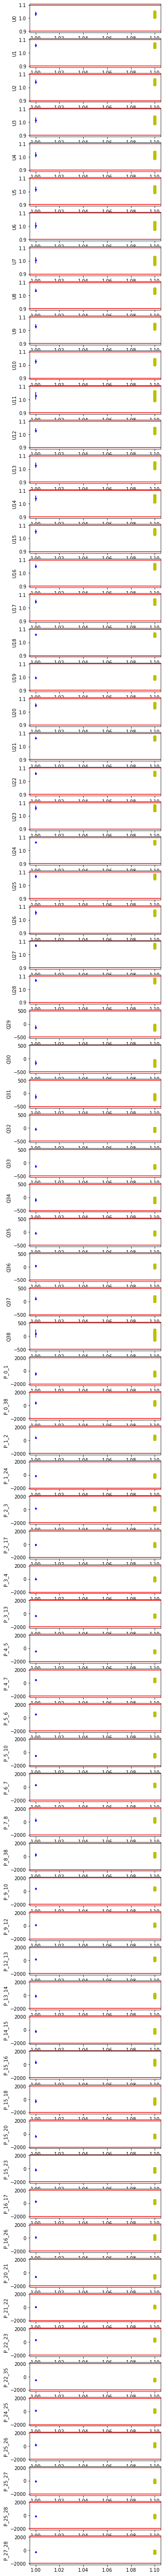

In [15]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

t1 = np.arange(1,2)
t2 = np.ones(5000) * 1.1 

x_names = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
            'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
            'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
            'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
            'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
            'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']
u_names = ['Pg0', 'Pg1', 'Pg2', 'Pg3', 'Pg4', 'Pg5', 'Pg6', 'Pg7', 'Pg8', 'Pg9']
d_names = ['Load_P1', 'Load_P2', 'Load_P3', 'Load_P4', 'Load_P5', 'Load_P6','Load_P7', 'Load_P8', 'Load_P9',
            'Load_P10', 'Load_P11', 'Load_P12', 'Load_P13', 'Load_P14', 'Load_P15','Load_P16', 'Load_P17', 'Load_P18',
            'Load_P19', 'Load_P20', 'Load_P21', 'RS_P1', 'RS_P2', 'RS_P3', 'RS_P4', 'RS_P5', 'RS_P6']


fig_x = plt.figure(figsize=(5, 100))
for i in range(x_TA1.shape[1]):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
            if i<29:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i]/345, color='y', label='MC PF')
                
                ax.axhline(y=1.1, xmin=0, xmax=1, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=1, color='r')
                
            elif i>28 and i<39:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='MC PF')
                
                ax.axhline(y=500,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-500, xmin=0, xmax=1, color='r')
                
            elif i>38 and i<89:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='MC PF')
                
                ax.axhline(y=2000,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-2000, xmin=0, xmax=1, color='r')
                
            
            ax.set_ylabel(x_names[i])   

## 2. GP 

### a) Mean value

In [16]:
P_cont = u
X_d = x_d
X_input = np.concatenate((P_cont, X_d), axis=1)

In [17]:
mean_pred = gp.predict_gp_mean(X_input)
out_gp_mean = np.array(mean_pred).reshape(1,-1)

out_gp_mean.shape

(1, 74)

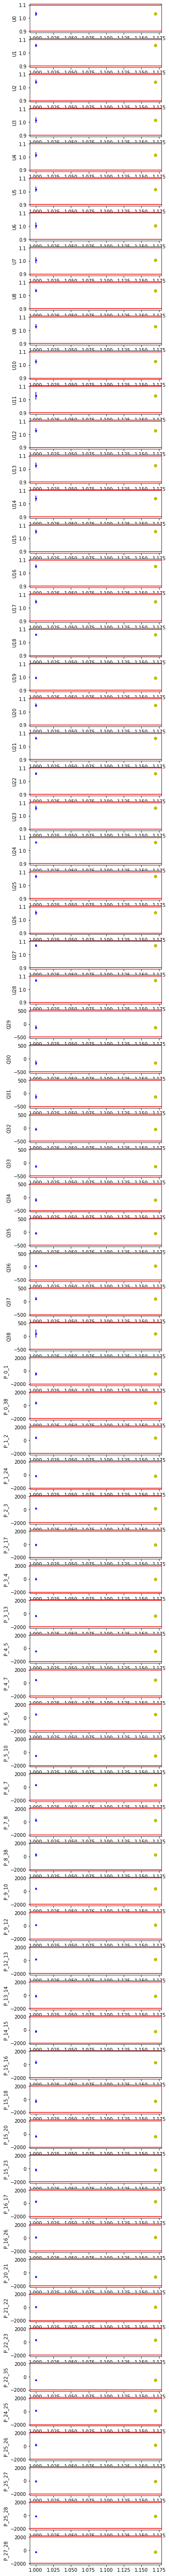

In [18]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

t1 = np.arange(1,2)
t2 = np.arange(1,2)+0.17


x_names = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
            'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
            'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
            'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
            'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
            'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']
u_names = ['Pg0', 'Pg1', 'Pg2', 'Pg3', 'Pg4', 'Pg5', 'Pg6', 'Pg7', 'Pg8', 'Pg9']
d_names = ['Load_P1', 'Load_P2', 'Load_P3', 'Load_P4', 'Load_P5', 'Load_P6','Load_P7', 'Load_P8', 'Load_P9',
            'Load_P10', 'Load_P11', 'Load_P12', 'Load_P13', 'Load_P14', 'Load_P15','Load_P16', 'Load_P17', 'Load_P18',
            'Load_P19', 'Load_P20', 'Load_P21', 'RS_P1', 'RS_P2', 'RS_P3', 'RS_P4', 'RS_P5', 'RS_P6']


fig_x = plt.figure(figsize=(5, 100))
for i in range(x_TA1.shape[1]):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
            if i<29:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_gp_mean[:, i]/345, color='y', label='MC GP')
                
                ax.axhline(y=1.1, xmin=0, xmax=1, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=1, color='r')
                
            elif i>28 and i<39:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_gp_mean[:, i], color='y', label='MC GP')
                
                ax.axhline(y=500,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-500, xmin=0, xmax=1, color='r')
                
            elif i>38 and i<89:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_gp_mean[:, i], color='y', label='MC GP')
                
                ax.axhline(y=2000,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-2000, xmin=0, xmax=1, color='r')
                
            
            ax.set_ylabel(x_names[i])   

### b) Uncertanty

In [19]:
P_cont = u
input_mean = x_d
input_std = np.sqrt(xd_std)

In [20]:
X_GP = df_pf_uncertanty.loc[:,['Pg0', 'Pg1', 'Pg2', 'Pg3', 'Pg4', 'Pg5', 'Pg6', 'Pg7', 'Pg8', 'Pg9',
            'Load_P1', 'Load_P2', 'Load_P3', 'Load_P4', 'Load_P5', 'Load_P6','Load_P7', 'Load_P8', 'Load_P9',
            'Load_P10', 'Load_P11', 'Load_P12', 'Load_P13', 'Load_P14', 'Load_P15','Load_P16', 'Load_P17', 'Load_P18',
            'Load_P19', 'Load_P20', 'Load_P21', 'RS_P1', 'RS_P2', 'RS_P3', 'RS_P4', 'RS_P5', 'RS_P6']] 
X_GP = np.array(X_GP)
X_GP.shape

(5000, 37)

In [21]:
gp_prediction_uncertanty = []

t = -time.time()
for i in range(X_GP.shape[0]):
    mean_pred = gp.predict_gp_mean(X_GP[i,:].reshape(1,-1))
    a = np.array(mean_pred).reshape(1,-1).tolist()[0]
    gp_prediction_uncertanty.append(a)
    
t += time.time()

print('Time of solver:', t)

out_gp_uncertanty = np.array(gp_prediction_uncertanty)
out_gp_uncertanty.shape

Time of solver: 1795.2489330768585


(5000, 74)

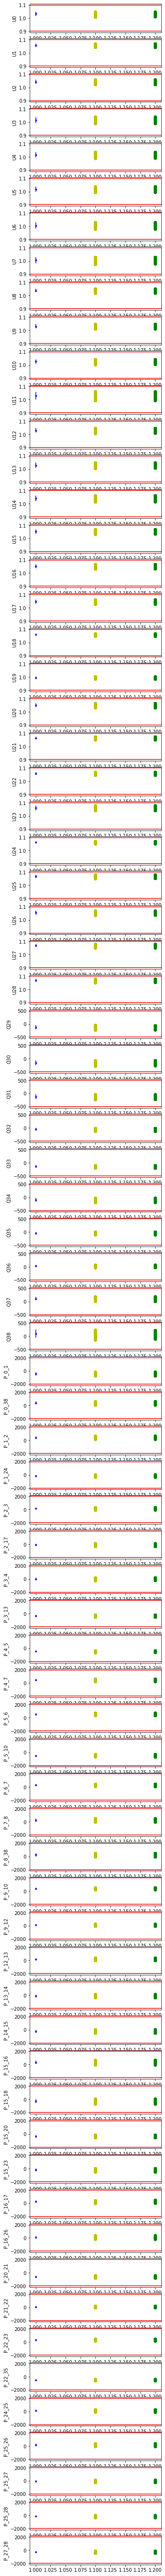

In [22]:
numcols = 2
numrows = int(np.ceil(x_TA1.shape[1] / numcols))

m = 1

t1 = np.arange(1,2)
t2 = np.ones(5000) + 0.1 
t3 = np.ones(5000) + 0.2

x_names = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16',
            'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',
            'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38',
            'P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
            'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
            'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']
u_names = ['Pg0', 'Pg1', 'Pg2', 'Pg3', 'Pg4', 'Pg5', 'Pg6', 'Pg7', 'Pg8', 'Pg9']
d_names = ['Load_P1', 'Load_P2', 'Load_P3', 'Load_P4', 'Load_P5', 'Load_P6','Load_P7', 'Load_P8', 'Load_P9',
            'Load_P10', 'Load_P11', 'Load_P12', 'Load_P13', 'Load_P14', 'Load_P15','Load_P16', 'Load_P17', 'Load_P18',
            'Load_P19', 'Load_P20', 'Load_P21', 'RS_P1', 'RS_P2', 'RS_P3', 'RS_P4', 'RS_P5', 'RS_P6']


fig_x = plt.figure(figsize=(5, 100))
for i in range(x_TA1.shape[1]):
            ax = fig_x.add_subplot(x_TA1.shape[1], 1, i + 1)
        
            if i<29:
                ax.errorbar(t1, x_TA1[:, i]/345, yerr= 3 * np.sqrt(s_TA1[:, i])/345, marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i]/345, color='y', label='MC PF')
                ax.scatter(t3, out_gp_uncertanty[:, i]/345, color='g', label='GP')
                
                ax.axhline(y=1.1, xmin=0, xmax=1, color='r')
                ax.axhline(y=0.9, xmin=0, xmax=1, color='r')
                
            elif i>28 and i<39:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='MC PF')
                ax.scatter(t3, out_gp_uncertanty[:, i], color='g', label='GP')
                
                ax.axhline(y=500,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-500, xmin=0, xmax=1, color='r')
                
            elif i>38 and i<89:
                ax.errorbar(t1, x_TA1[:, i], yerr= 3 * np.sqrt(s_TA1[:, i]), marker='.',
                        linestyle='None', color='b', label='TA1')
                
                ax.scatter(t2, out_pf_uncertanty[:, i], color='y', label='MC PF')
                ax.scatter(t3, out_gp_uncertanty[:, i], color='g', label='GP')
                
                ax.axhline(y=2000,  xmin=0, xmax=1, color='r')
                ax.axhline(y=-2000, xmin=0, xmax=1, color='r')
                
            
            ax.set_ylabel(x_names[i]) 

------------

#  Monte Carlo (PF and GP) vs analitical GP 

In [23]:
def MonteCarlo(df, num_of_labels, num_of_points, num_of_sampl=5000, name='PF'):
    
    lb = []
    ub = []
    for i in range(num_of_labels):
        for j in range(num_of_points):
            
            if name == 'PF':
                data = out_pf_uncertanty[j*num_of_sampl:(j+1)*num_of_sampl,i]
            elif name == 'GP':
                data = out_gp_uncertanty[j*num_of_sampl:(j+1)*num_of_sampl,i]
                
            lb_5 = np.percentile(data, 0.27)
            ub_95 = np.percentile(data, 99.73)
            
            #lb_5 = np.percentile(data,  5)
            #ub_95 = np.percentile(data, 95.)
            
            lb.append(lb_5)
            ub.append(ub_95)
            
    return np.array(lb), np.array(ub)

In [24]:
# GP

#mean
g = []
for i in range(out_gp_mean.shape[1]):
    for j in range(out_gp_mean.shape[0]):
        g.append(out_gp_mean[j, i])
        
#margins
l_q, u_q = MonteCarlo(out_gp_uncertanty, 74, 1, name='GP')

lb_q = l_q.reshape(1, 74)
ub_q = u_q.reshape(1, 74)

lb_q = g - lb_q
ub_q = ub_q - g

bound_q = np.concatenate((lb_q, ub_q), axis=0)
bound_q.shape

(2, 74)

In [25]:
# Power Flow

#mean
m = []
for i in range(out_pf_mean.shape[1]):
    for j in range(out_pf_mean.shape[0]):
        m.append(out_pf_mean[j, i])
        
#margins        
l, u = MonteCarlo(out_pf_uncertanty, 74, 1, name='PF')

lb = l.reshape(1, 74)
ub = u.reshape(1, 74)

lb = m - lb
ub = ub - m

bound = np.concatenate((lb, ub), axis=0)
bound.shape

(2, 74)

-----------

# Uncertanty estimation

In [20]:
n=3

pred_uncertanty_TA1 = n * np.sqrt(s_TA1[:, 0])
pred_uncertanty_TA1[:29] = pred_uncertanty_TA1[:29]/345
pred_uncertanty_TA1[29:] = pred_uncertanty_TA1[29:]/400

pred_uncertanty_TA2 = n * np.sqrt(s_TA2[:, 0])
pred_uncertanty_TA2[:29] = pred_uncertanty_TA2[:29]/345
pred_uncertanty_TA2[29:] = pred_uncertanty_TA2[29:]/400

pred_uncertanty_EM = n * np.sqrt(s_EM[:, 0])
pred_uncertanty_EM[:29] = pred_uncertanty_EM[:29]/345
pred_uncertanty_EM[29:] = pred_uncertanty_EM[29:]/400

real_up_uncertanty = []
real_down_uncertanty = []
gp_up_uncertanty = []
gp_down_uncertanty = []

for i in range(74):
    real_up_uncertanty.append((bound[0, i*1:(i+1)*1][0]))
    real_down_uncertanty.append((bound[1, i*1:(i+1)*1][0]))
    gp_up_uncertanty.append((bound_q[0, i*1:(i+1)*1][0]))
    gp_down_uncertanty.append((bound_q[1, i*1:(i+1)*1][0]))
    
real_up_uncertanty = np.array(real_up_uncertanty)
real_down_uncertanty = np.array(real_down_uncertanty)

gp_up_uncertanty = np.array(gp_up_uncertanty)
gp_down_uncertanty = np.array(gp_down_uncertanty)

real_up_uncertanty[:29] = real_up_uncertanty[:29]/345
real_up_uncertanty[29:] = real_up_uncertanty[29:]/400
real_down_uncertanty[:29] = real_down_uncertanty[:29]/345
real_down_uncertanty[29:] = real_down_uncertanty[29:]/400

gp_up_uncertanty[:29] = gp_up_uncertanty[:29]/345
gp_up_uncertanty[29:] = gp_up_uncertanty[29:]/400
gp_down_uncertanty[:29] = gp_down_uncertanty[:29]/345
gp_down_uncertanty[29:] = gp_down_uncertanty[29:]/400

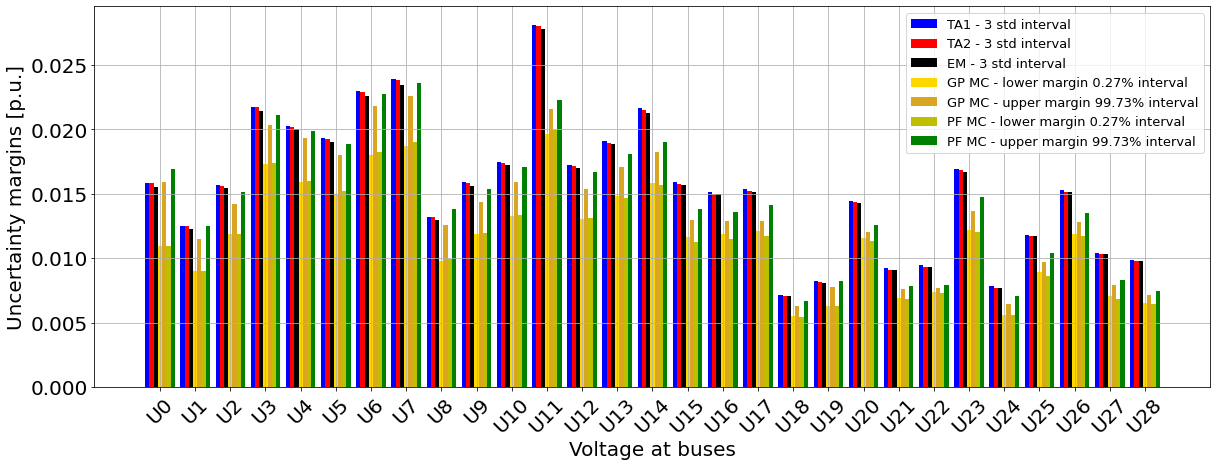

In [52]:
w=0.12

x = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
     'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(20,7))

plt.bar(bar1, pred_uncertanty_TA1[:29], w, label='TA1 - 3 std interval', color='b')
plt.bar(bar2, pred_uncertanty_TA2[:29], w, label='TA2 - 3 std interval', color='r')
plt.bar(bar3, pred_uncertanty_EM[:29], w, label='EM - 3 std interval', color='k')
plt.bar(bar4, gp_down_uncertanty[:29], w, label='GP MC - lower margin 0.27% interval', color='gold')
plt.bar(bar5, gp_up_uncertanty[:29], w, label='GP MC - upper margin 99.73% interval', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[:29], w, label='PF MC - lower margin 0.27% interval', color='y')
plt.bar(bar7, real_up_uncertanty[:29], w, label='PF MC - upper margin 99.73% interval', color='g')

plt.xticks(bar1 + 2*w + w, x)
plt.ylabel('Uncertainty margins [p.u.]', fontsize=20)
plt.xlabel('Voltage at buses', fontsize=20)
plt.legend(fontsize=13)
plt.grid()
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.savefig('figures/U_uncertanty_bar_IEEE39.png', bbox_inches = 'tight')

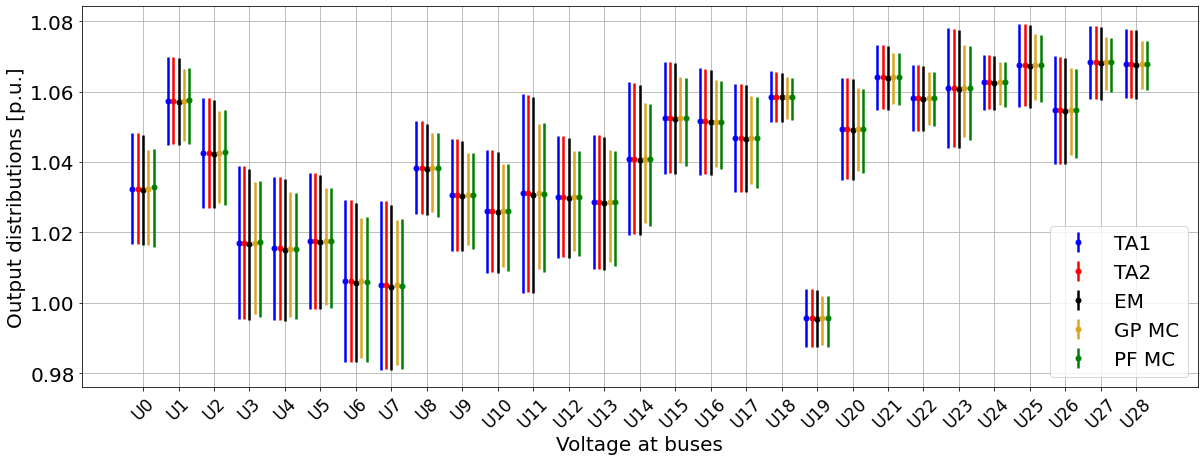

In [55]:
m=29
x = ['U0', 'U1','U2', 'U3', 'U4', 'U5', 'U6','U7', 'U8','U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 
     'U17', 'U18','U19', 'U20', 'U21', 'U22', 'U23','U24', 'U25','U26', 'U27', 'U28',]

t = np.arange(1,m+1)-0.3
t1 = np.arange(1,m+1)-0.15
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.15
t4 = np.arange(1,m+1)+0.3

plt.figure(figsize=(20, 7))
plt.errorbar(t, x_TA1[:29].flatten()/345, yerr= 3 * np.sqrt(s_TA1[:29].flatten())/345, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='b', label='TA1')
plt.errorbar(t1, x_TA2[:29].flatten()/345, yerr= 3 * np.sqrt(s_TA2[:29].flatten())/345, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='r', label='TA2')
plt.errorbar(t2, x_EM[:29].flatten()/345, yerr= 3 * np.sqrt(s_EM[:29].flatten())/345, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='k', label='EM')

plt.errorbar(t3, out_gp_mean[:, :29].flatten()/345, yerr=bound_q[:, :29]/345, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, :29].flatten()/345, yerr=bound[:, :29]/345, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='g', label='PF MC')

plt.grid()
plt.ylabel('Output distributions [p.u.]', fontsize=20)
plt.xlabel('Voltage at buses', fontsize=20)
plt.legend(fontsize=20, loc=4)
plt.xticks(t2, x, fontsize=17, rotation=45)
plt.yticks(fontsize=20)

plt.savefig('figures/U_uncertanty_error_IEEE39.png', bbox_inches = 'tight')

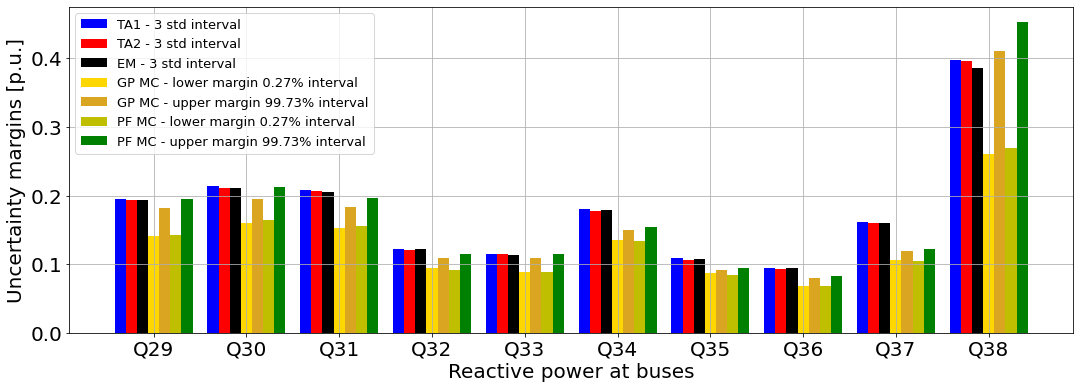

In [56]:
w=0.12
x = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34','Q35', 'Q36', 'Q37', 'Q38']


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]

plt.figure(figsize=(18,6))

plt.bar(bar1, pred_uncertanty_TA1[29:39], w, label='TA1 - 3 std interval', color='b')
plt.bar(bar2, pred_uncertanty_TA2[29:39], w, label='TA2 - 3 std interval', color='r')
plt.bar(bar3, pred_uncertanty_EM[29:39], w, label='EM - 3 std interval', color='k')
plt.bar(bar4, gp_down_uncertanty[29:39], w, label='GP MC - lower margin 0.27% interval', color='gold')
plt.bar(bar5, gp_up_uncertanty[29:39], w, label='GP MC - upper margin 99.73% interval', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[29:39], w, label='PF MC - lower margin 0.27% interval', color='y')
plt.bar(bar7, real_up_uncertanty[29:39], w, label='PF MC - upper margin 99.73% interval', color='g')

plt.xticks(bar1 + 2*w + w, x)
plt.ylabel('Uncertainty margins [p.u.]', fontsize=20)
plt.xlabel('Reactive power at buses', fontsize=20)
plt.legend(fontsize=13)
plt.grid()
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)

plt.savefig('figures/Q_uncertanty_bar_IEEE39.png', bbox_inches = 'tight')

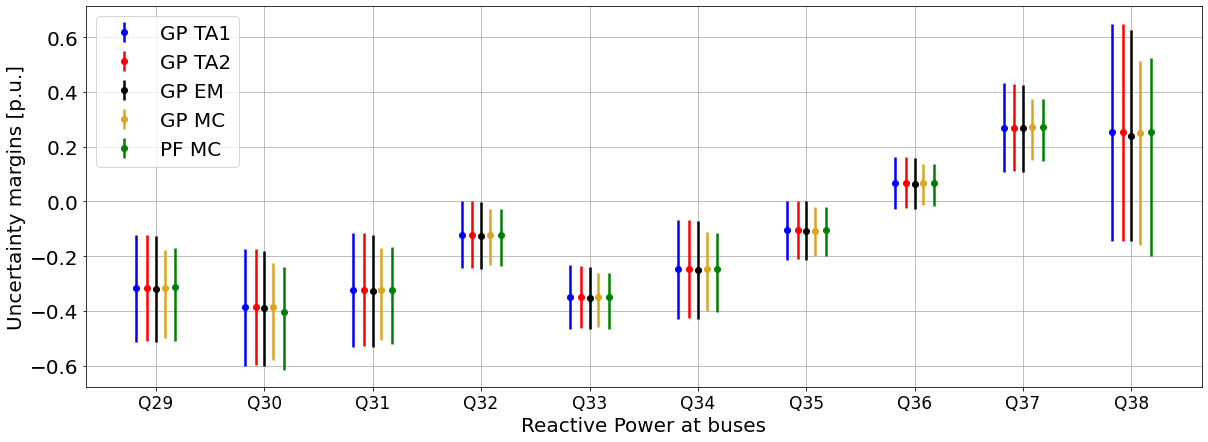

In [57]:
m=10
t = np.arange(1,m+1)-0.18
t1 = np.arange(1,m+1)-0.08
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.08
t4 = np.arange(1,m+1)+0.18

plt.figure(figsize=(20, 7))
plt.errorbar(t, x_TA1[29:39].flatten()/400, yerr= 3 * np.sqrt(s_TA1[29:39].flatten())/400, marker='.',
                         ms=12, lw=2.5, linestyle='None', color='b', label='GP TA1')
plt.errorbar(t1, x_TA2[29:39].flatten()/400, yerr= 3 * np.sqrt(s_TA2[29:39].flatten())/400, marker='.',
                         ms=12, lw=2.5, linestyle='None', color='r', label='GP TA2')
plt.errorbar(t2, x_EM[29:39].flatten()/400, yerr= 3 * np.sqrt(s_EM[29:39].flatten())/400, marker='.',
                         ms=12, lw=2.5, linestyle='None', color='k', label='GP EM')

plt.errorbar(t3, out_gp_mean[:, 29:39].flatten()/400, yerr=bound_q[:, 29:39]/400, marker='.',
                         ms=12, lw=2.5, linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, 29:39].flatten()/400, yerr=bound[:, 29:39]/400, marker='.',
                         ms=12, lw=2.5, linestyle='None', color='g', label='PF MC')

plt.grid()
plt.ylabel('Uncertainty margins [p.u.]', fontsize=20)
plt.xlabel('Reactive Power at buses', fontsize=20)
plt.legend(fontsize=20, loc=2)
plt.xticks(t2, x, fontsize=17, rotation=0)
plt.yticks(fontsize=20)

plt.savefig('figures/Q_uncertanty_error_IEEE39.png', bbox_inches = 'tight')

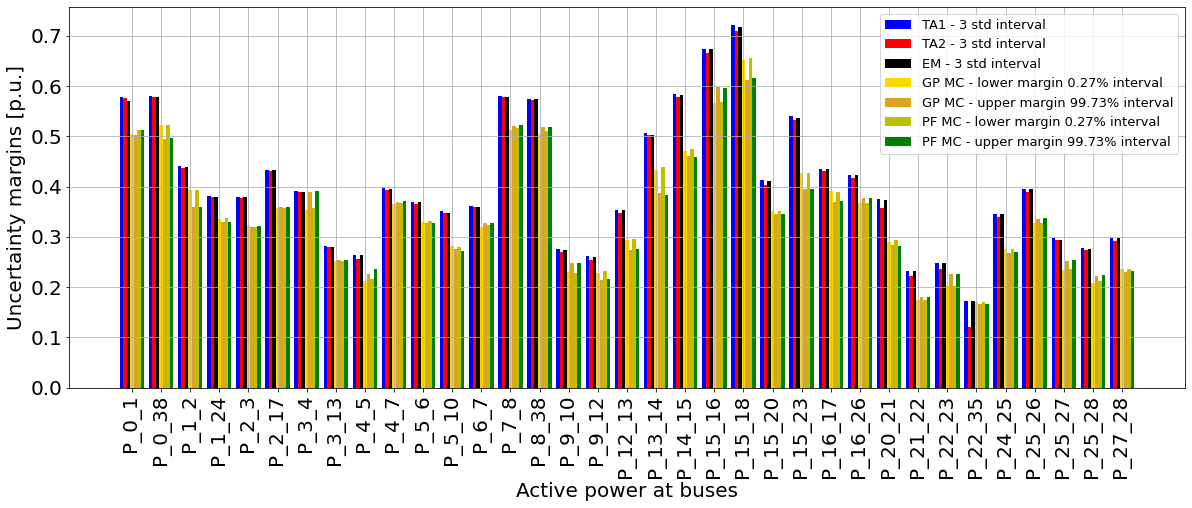

In [58]:
w=0.12
x = ['P_0_1', 'P_0_38', 'P_1_2', 'P_1_24', 'P_2_3', 'P_2_17', 'P_3_4', 'P_3_13', 'P_4_5', 'P_4_7', 'P_5_6', 'P_5_10', 'P_6_7',
     'P_7_8', 'P_8_38', 'P_9_10', 'P_9_12', 'P_12_13', 'P_13_14', 'P_14_15', 'P_15_16', 'P_15_18', 'P_15_20', 'P_15_23', 'P_16_17', 'P_16_26',
     'P_20_21', 'P_21_22','P_22_23', 'P_22_35', 'P_24_25', 'P_25_26', 'P_25_27', 'P_25_28', 'P_27_28']



bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]
bar6 = [i+w for i in bar5]
bar7 = [i+w for i in bar6]


plt.figure(figsize=(20,7))

plt.bar(bar1, pred_uncertanty_TA1[39:], w, label='TA1 - 3 std interval', color='b')
plt.bar(bar2, pred_uncertanty_TA2[39:], w, label='TA2 - 3 std interval', color='r')
plt.bar(bar3, pred_uncertanty_EM[39:], w, label='EM - 3 std interval', color='k')
plt.bar(bar4, gp_down_uncertanty[39:], w, label='GP MC - lower margin 0.27% interval', color='gold')
plt.bar(bar5, gp_up_uncertanty[39:], w, label='GP MC - upper margin 99.73% interval', color='goldenrod')
plt.bar(bar6, real_down_uncertanty[39:], w, label='PF MC - lower margin 0.27% interval', color='y')
plt.bar(bar7, real_up_uncertanty[39:], w, label='PF MC - upper margin 99.73% interval', color='g')

plt.xticks(bar1 + 2*w + w, x, rotation=90)
plt.ylabel('Uncertainty margins [p.u.]', fontsize=20)
plt.xlabel('Active power at buses', fontsize=20)
plt.legend(fontsize=13)
plt.grid()
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)

plt.savefig('figures/P_uncertanty_bar_IEEE39.png', bbox_inches = 'tight')

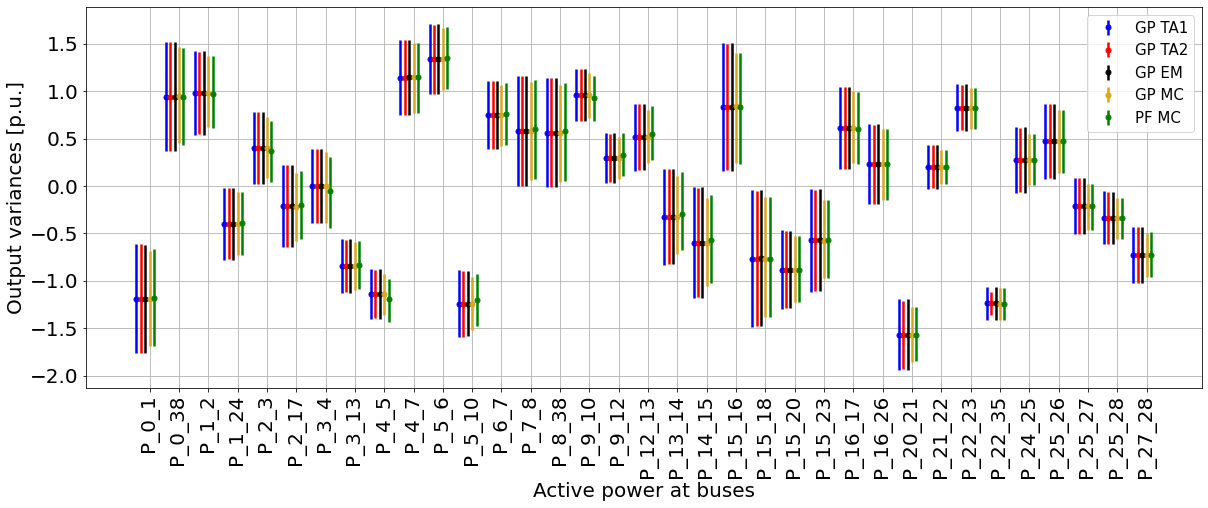

In [59]:
m=35
t = np.arange(1,m+1)-0.3
t1 = np.arange(1,m+1)-0.15
t2 = np.arange(1,m+1)
t3 = np.arange(1,m+1)+0.15
t4 = np.arange(1,m+1)+0.3

plt.figure(figsize=(20, 7))
plt.errorbar(t, x_TA1[39:].flatten()/400, yerr= 3 * np.sqrt(s_TA1[39:].flatten())/400, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='b', label='GP TA1')
plt.errorbar(t1, x_TA2[39:].flatten()/400, yerr= 3 * np.sqrt(s_TA2[39:].flatten())/400, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='r', label='GP TA2')
plt.errorbar(t2, x_EM[39:].flatten()/400, yerr= 3 * np.sqrt(s_EM[39:].flatten())/400, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='k', label='GP EM')

plt.errorbar(t3, out_gp_mean[:, 39:].flatten()/400, yerr=bound_q[:, 39:]/400, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='goldenrod', label='GP MC')
plt.errorbar(t4, out_pf_mean[:, 39:].flatten()/400, yerr=bound[:, 39:]/400, marker='.',
                        ms=10, lw=2.5, linestyle='None', color='g', label='PF MC')


plt.grid()
plt.ylabel('Output variances [p.u.]', fontsize=20)
plt.xlabel('Active power at buses', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(t3, x, fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('figures/P_uncertanty_error_IEEE39.png', bbox_inches = 'tight')

------------------

# Square and Absolute Errors

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [53]:
out_pf_mean_pu = np.zeros((1,74))
x_TA1_pu = np.zeros((1,74))
x_EM_pu = np.zeros((1,74))

out_pf_mean_pu[:, :29] = out_pf_mean[:, :29]/345
out_pf_mean_pu[:, 29:] = out_pf_mean[:, 29:]/400

x_TA1_pu[:, :29] = x_TA1[:, :29]/345
x_TA1_pu[:, 29:] = x_TA1[:, 29:]/400

x_EM_pu[:, :29] = x_EM[:, :29]/345
x_EM_pu[:, 29:] = x_EM[:, 29:]/400

0.013723169229347862

### TA

In [44]:
RMSE_average = mean_squared_error(out_pf_mean_pu.T, x_TA1_pu.T, multioutput='uniform_average', squared=False)
MAE_average = mean_absolute_error(out_pf_mean_pu.T, x_TA1_pu.T, multioutput='uniform_average')

RMSE_row = mean_squared_error(out_pf_mean_pu, x_TA1_pu, multioutput='raw_values', squared=False)
MAE_row = mean_absolute_error(out_pf_mean_pu, x_TA1_pu, multioutput='raw_values')

In [45]:
print('RMSE_avrage:', RMSE_average)
print('MAE_average:', MAE_average)

print('')

print('RMSE_row:', RMSE_row)
print('MAE_row:', MAE_row)

RMSE_avrage: 0.013723169229347862
MAE_average: 0.006640639939750136

RMSE_row: [3.30298826e-04 1.87523806e-04 1.92402190e-04 2.95622956e-05
 1.05167765e-04 1.62562982e-04 1.63367988e-04 1.75301047e-04
 1.78894654e-04 4.61241343e-05 5.25185662e-05 7.40411061e-05
 5.72328537e-05 5.34873076e-05 1.96489677e-05 3.58191672e-05
 3.60059873e-05 5.41401961e-05 9.37332222e-06 1.22162219e-05
 1.14535554e-06 2.57220379e-05 3.71223283e-05 6.02039467e-05
 2.01807312e-05 8.38755935e-05 4.66875676e-05 3.92537908e-05
 2.89318529e-05 2.32863386e-03 1.55853434e-02 2.91739531e-04
 1.11819809e-04 4.11586727e-04 3.44049151e-04 3.87702637e-04
 6.50438596e-05 2.81227321e-04 2.66546394e-03 9.47808615e-03
 8.73499375e-03 6.32543476e-03 1.56997611e-03 3.38632709e-02
 1.23687442e-02 4.85288672e-02 9.50007623e-03 5.29506096e-02
 2.01608641e-03 1.27644959e-02 3.64711524e-02 1.11861908e-02
 1.38128059e-02 1.39186856e-02 3.14633787e-02 2.90501560e-02
 2.97724313e-02 3.26581979e-02 2.87920808e-02 5.73971106e-03
 2.290

### EM

In [34]:
RMSE_average = mean_squared_error(out_pf_mean_pu.T, x_EM_pu.T, multioutput='uniform_average', squared=False)
MAE_average = mean_absolute_error(out_pf_mean_pu.T, x_EM_pu.T, multioutput='uniform_average')

RMSE_row = mean_squared_error(out_pf_mean_pu, x_EM_pu, multioutput='raw_values', squared=False)
MAE_row = mean_absolute_error(out_pf_mean_pu, x_EM_pu, multioutput='raw_values')

In [35]:
print('RMSE_avrage:', RMSE_average)
print('MAE_average:', MAE_average)

print('')

print('RMSE_row:', RMSE_row)
print('MAE_row:', MAE_row)

RMSE_avrage: 0.01353728253670315
MAE_average: 0.006993373582516124

RMSE_row: [0.00073367 0.00047411 0.00053702 0.00045522 0.0003241  0.00021469
 0.00027913 0.00030826 0.00026148 0.00029767 0.00032905 0.00043962
 0.00030755 0.00028042 0.00032131 0.0002446  0.0001922  0.00028816
 0.00022463 0.00018062 0.00022065 0.00012308 0.00011293 0.00021098
 0.00027599 0.0003394  0.00030358 0.00029386 0.00020685 0.00711488
 0.01115249 0.00394275 0.00408336 0.00231469 0.00247802 0.00125143
 0.00296473 0.0037872  0.01448885 0.00897321 0.00844893 0.00607075
 0.00133007 0.03325253 0.01200208 0.04764741 0.00926907 0.05241778
 0.00179113 0.0127184  0.03510578 0.01074316 0.01321473 0.01357482
 0.030682   0.02825962 0.02927268 0.03150069 0.02855279 0.00562355
 0.00279918 0.0004769  0.00065249 0.01391197 0.0009622  0.00016664
 0.00230251 0.00122543 0.0041131  0.00483084 0.00078124 0.00068137
 0.00079103 0.00100436]
MAE_row: [0.00073367 0.00047411 0.00053702 0.00045522 0.0003241  0.00021469
 0.00027913 0.0003